#  Disentangled Sequential Variational Autoencoder using Tensorflow Probability

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_03_DisentangledSequentialAE_TFP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_03_DisentangledSequentialAE_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Introduction

[TF Probability example of disentangled VAE](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py) from [Li and Mandt, ICML 2018](https://arxiv.org/pdf/1803.02991.pdf).

> This notebook is in very early stages of development and is not ready for public consumption.

To understand the details of this notebook you must first go through the 05_04_betaVAE_TFP notebook.

### Definition

This kind of model deviates from a $\beta$-VAE by using more explicit architecture to separately encode different dimensions of the data. The training is designed so that the model learns to encode a latent representation that is split into features that **disentangle** relevant and interpretable features. With careful model formulation, this can be used to disentangle time-dependent features (dynamics) and static features (content / context).

## Prepare Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys


try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    !pip install git+https://github.com/SachsLab/indl.git
    !pip install -q kaggle
    !pip install --upgrade tensorflow-probability
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
if True:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

## Prepare Data

While I'm figuring this out, I'll use a contrived dataset.

Let's assume that we have N_LATENT different latent variables. The baseline value for each latent variable is 0.5 with white noise (mean=0, std=0.1) at each timestep.

Each latent variable evolves over time following a sigmoid, with the amplitudes of each set of sigmoids being a random vector drawn from a (N_LATENT) multivariate distribution. There are N_CLASSES distinct distributions, 1 for each class.

The evolved class-dependent latent variable is then mixed through a static mixing matrix to yield N_SENSORS sensor-space signals.

In [5]:
from indl.misc.sigfuncs import sigmoid
from functools import partial


N_LATENTS = 4
N_SENSORS = 32
N_CLASSES = 5
FS = 25
DURATION = 2  # seconds
n_timesteps = int(DURATION * FS)
tvec = np.arange(n_timesteps) / FS


def make_signal_generator(n_latents=N_LATENTS, n_sensors=N_SENSORS,
                          n_classes=N_CLASSES, n_timesteps=n_timesteps,
                          seed=99):
    np.random.seed(seed)
    t = np.arange(n_timesteps) / FS
    f_sig = partial(sigmoid, B=5, x_offset=1.0)
    class_amps = np.random.uniform(low=-1.0, high=1.0, size=(N_CLASSES, N_LATENTS))
    class_amps /= np.sum(np.abs(class_amps), axis=1, keepdims=True)
    f_sig = partial(sigmoid, B=5, x_offset=1.0)
    mix_mat = np.random.randn(N_SENSORS, N_LATENTS)
    mix_mat /= np.sum(np.abs(mix_mat), axis=1, keepdims=True)
    
    def draw_sample(class_ix):
        latent_mods = class_amps[class_ix, :, None] * f_sig(t)[None, :]
        latent_protos = 0.5 * np.ones((N_LATENTS, 1)) + 0.1 * np.random.randn(N_LATENTS, n_timesteps)
        latent_protos /= np.std(latent_protos, axis=1, keepdims=True)
        latent_class_dat = latent_mods * latent_protos  # (N_LATENTS, n_timesteps)
        sensor_class_dat = mix_mat @ latent_class_dat
        
        sig = sensor_class_dat.T
        return sig
    
    return draw_sample

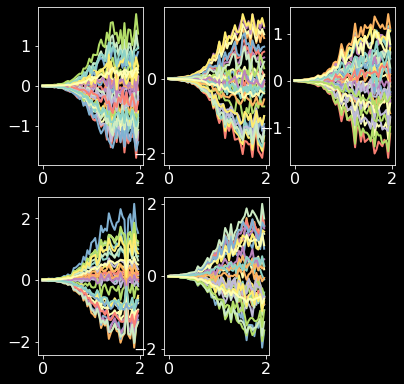

In [6]:
sig_gen = make_signal_generator()
for class_ix in range(N_CLASSES):
    plt.subplot(2, 3, class_ix + 1)
    plt.plot(tvec, sig_gen(class_ix))
plt.show()

In [7]:
N_TRIALS = 10000
BATCH_SIZE = 8

sig_gen = make_signal_generator()
Y = np.random.randint(0, high=N_CLASSES, size=N_TRIALS)
X = np.stack([sig_gen(_) for _ in Y])
dataset = tf.data.Dataset.from_tensor_slices((X, Y)).batch(BATCH_SIZE, drop_remainder=True)
dataset.element_spec

(TensorSpec(shape=(8, 50, 32), dtype=tf.float64, name=None),
 TensorSpec(shape=(8,), dtype=tf.int32, name=None))

### Modify dataset

Using Keras' training requires the dataset to be an x,y tuple, where x is the input and y are the values to which the model output will be compared. The autoencoder tries to reconstruct the input, thus the y values are just a copy of the x values. We do this by mapping a function to the dataset, where the function is a simple lambda that takes in x,y and returns x,x.

However, our model generates 3 outputs, so Keras expects 3-length tuple in y. So we map our data from x,y --> x,(x, x, x)

Note, only the last output of the model is compared to the input, the others are used for loss calculations that do not depend on the model outputs. We can save memory by mapping the first two outputs to empty tensors.

In [8]:
ae_dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32),
                                       (tf.zeros(0, dtype=tf.float32), tf.zeros(0, dtype=tf.float32),
                                        tf.cast(x, tf.float32))))
print(ae_dataset.element_spec)

(TensorSpec(shape=(8, 50, 32), dtype=tf.float32, name=None), (TensorSpec(shape=(0,), dtype=tf.float32, name=None), TensorSpec(shape=(0,), dtype=tf.float32, name=None), TensorSpec(shape=(8, 50, 32), dtype=tf.float32, name=None)))


## Build Model

Most of the details and explanation can be found in the 05_04_betaVAE_TFP notebook.

In [9]:
from indl.model.tfp import LearnableMultivariateNormalDiag, LearnableMultivariateNormalDiagCell
# Specify constants
LATENT_SIZE_STATIC = 8
LATENT_OFFDIAG_STATIC = False  # Set to False to restrict latents to being independent (diagonal covariance)
LATENT_SIZE_DYNAMIC = 4
# LATENT_OFFDIAG_DYNAMIC = False  # Always False
HIDDEN_SIZE = 12
BATCH_SIZE = 8
CLIP_NORM = 1e10
LEARNING_RATE = 0.0001
NUM_RECONSTRUCTION_SAMPLES = 1
NUM_SAMPLES = 4
RANDOM_SEED = 42
MAX_STEPS = 10000
N_GRU = 16
N_EPOCHS = 30

In [85]:
tfb = tfp.bijectors
def make_mvn_prior(ndim, trainable=False, offdiag=False):
    if not trainable:
        if offdiag:
            # With covariances
            # Note: Diag must be > 0, upper triangular must be 0, and lower triangular may be != 0.
            prior = tfd.MultivariateNormalTriL(
                loc=tf.zeros(ndim),
                scale_tril=tf.eye(ndim)
            )
        else:
            # TODO: Determine if there is a reason to use one of these over the other.
            if True:
                prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ndim), scale_diag=tf.ones(ndim))
            else:
                prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ndim), scale=1),
                                        reinterpreted_batch_ndims=1)
    else:
        # Note, in TransformedVariable, the initial value should be that AFTER transform
        if offdiag:
            n_scale = tfd.MultivariateNormalTriL.params_size(ndim) - ndim
            prior = tfd.MultivariateNormalTriL(
                loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32)),
                scale_tril=tfp.util.TransformedVariable(
                    tf.random.normal([n_scale], mean=1.0, stddev=0.1, dtype=tf.float32),
                    tfb.FillScaleTriL())
            )
        else:
            scale_shift = np.log(np.exp(1) - 1).astype(np.float32)
            prior = tfd.MultivariateNormalDiag(
                loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32)),
                scale_diag=tfp.util.TransformedVariable(
                    tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                    bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(scale_shift)])
                )
            )
    return prior

In [91]:
def make_mvn_dist_fn(_x_, ndim, offdiag=False):
    _loc = tfkl.Dense(ndim)(_x_)
    if offdiag:
        _scale = tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(ndim) - ndim)(_x_)
        _scale = tfp.bijectors.FillScaleTriL()(_scale)  # softplus(x+0.5413) + 1e-5 --> lower tri mat
        make_dist_fn = lambda t: tfd.MultivariateNormalTriL(loc=t[0], scale_tril=t[1])
    else:
        _scale = tfkl.Dense(ndim)(_x_)
        _scale = tf.math.softplus(_scale + np.log(np.exp(1) - 1)) + 1e-5
        # make_dist_fn = lambda t: tfd.Independent(tfd.Normal(loc=t[0], scale=t[1]))
        make_dist_fn = lambda t: tfd.MultivariateNormalDiag(loc=t[0], scale_diag=t[1])
    return make_dist_fn, [_loc, _scale]

In [92]:
K.clear_session()
K.set_floatx('float32')
tf.random.set_seed(RANDOM_SEED)

In [93]:
kl_beta = K.variable(value=0.0)
kl_beta._trainable = False

def kl_beta_warmup(epoch, ramp_epochs=10):
    new_beta_value = tf.minimum(1.0, epoch/ramp_epochs)
    new_beta_value = new_beta_value * BATCH_SIZE  #  / N_TRIALS
    K.set_value(kl_beta, new_beta_value)
    
# Add the following to the list of model.fit callbacks.
kl_beta_cb = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, log: kl_beta_warmup(epoch, ramp_epochs=5))

### Input

When working with real data we would probably add layers to do some minimal feature extraction (e.g., temporal convolution and spatial convolution -- EEGNet-light). Here we just copy the inputs to the features tensor.

In [94]:
# Input
_input = tfkl.Input(shape=(n_timesteps, N_SENSORS))

# TODO: Basic feature extractor (aka Compressor)
N_FEATS = N_SENSORS
_features = _input  # _features shape: (batch, timesteps, feat_dim)

In [ ]:
# Debug
if False:
    _input = tfkl.Input(shape=(n_timesteps, N_SENSORS))
    _x1 = tfkl.Bidirectional(
        tfkl.LSTM(HIDDEN_SIZE, return_sequences=False),
        merge_mode="sum")(_input)  # _x1 shape: (batch, hidden_size)
    make_dist_fn, params = make_mvn_dist_fn(_x1, LATENT_SIZE_STATIC, offdiag=LATENT_OFFDIAG_STATIC)
    q_f = tfpl.DistributionLambda(
        name="q_f",
        make_distribution_fn=make_dist_fn,
        convert_to_tensor_fn=lambda s: s.sample(NUM_SAMPLES),
    )(params)
    tmp_model = tf.keras.Model(inputs=_input, outputs=[q_f])
    tmp_model(x_in).mean()

### Encoder
$$q(z_{1:T}, f | x_{1:T}) = q(f | x_{1:T}) q(z_{1:T} | f, x_{1:T})$$

Distribution of latents $z_t$ (dynamic) and $f$ (static), conditioned on input sequence $x_t$.

##### Static Encoder (f)
$$q(f | x_{1:T})$$
Multivariate normal, conditioned on full sequence of features (i.e., compressed x). Features pass through bidirectional LSTM, then through affine, to yield distribution parameters.

In [95]:
_x1 = tfkl.Bidirectional(
    tfkl.LSTM(HIDDEN_SIZE, return_sequences=False),
    merge_mode="sum")(_features)  # _x1 shape: (batch, hidden_size)
make_dist_fn, params = make_mvn_dist_fn(_x1, LATENT_SIZE_STATIC, offdiag=LATENT_OFFDIAG_STATIC)
q_f = tfpl.DistributionLambda(
    name="q_f",
    make_distribution_fn=make_dist_fn,
    convert_to_tensor_fn=lambda s: s.sample(NUM_SAMPLES),
)(params)
_f_sample = tf.convert_to_tensor(q_f)  # Used for KL-divergence calculation in next cell.

# Both the dynamic encoder and the decoder require static samples to be repeated
# along the time axis. Do this with broadcast-add of zeros.
# Note that there are several tfkl layers that COULD help but they don't like distributions,
# so we use tf operations.
_static_sample = _f_sample[..., tf.newaxis, :] + tf.zeros([n_timesteps, 1])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [96]:
static_prior = make_mvn_prior(LATENT_SIZE_STATIC, trainable=True, offdiag=LATENT_OFFDIAG_STATIC)
#static_prior = LearnableMultivariateNormalDiag(LATENT_SIZE_STATIC)()
def get_static_loss_fn(use_exact_kl=True):
    if use_exact_kl:
        return lambda _, qf_out: tfd.kl_divergence(qf_out, static_prior)
    else:
        return lambda _, qf_out: qf_out.log_prob(_f_sample) - static_prior.log_prob(_f_sample)

##### Dynamic Encoder ($z_t$)

$q(z_t | x_{1:T}, f)$

Multivariate normal distribution **at each timestep**, conditioned on $x_t$ **and $f$ (full only, not factorized)**. Features and a sample of the static latent $f$ are concatenated, passed through bidirectional LSTM (return_sequences=True), then RNN, and finally affine to yield distribution parameters.

In [97]:
# _features needs to be repeated NUM_SAMPLES on a new samples axis at axis=0.
_x2 = _features[tf.newaxis, ...] + tf.zeros([NUM_SAMPLES, 1, 1, 1])
# Concatenate _x2 (features) and _static_sample
_x2 = tfkl.Concatenate()([_x2, _static_sample])  # (samples, batch, timesteps, feat_dim+latent_static)
# Collapse samples + batch dims  -- required by LSTM
_x2 = tf.reshape(_x2, [-1] + _x2.shape.as_list()[-2:])  # (samples*batch, T, feat+lat_stat)
# Run _x2 through bidirectional lstm then a simple RNN,
# then use output to parameterize distribution over latent variable z_t.
_x2 = tfkl.Bidirectional(
    tfkl.LSTM(HIDDEN_SIZE, return_sequences=True),
    merge_mode="sum")(_x2)
_x2 = tfkl.SimpleRNN(HIDDEN_SIZE, return_sequences=True)(_x2)
# Restore samples dim?
_x2 = tf.reshape(_x2, [NUM_SAMPLES, -1, n_timesteps, HIDDEN_SIZE])
make_dist_fn, params = make_mvn_dist_fn(_x2, LATENT_SIZE_DYNAMIC, offdiag=False)
q_z = tfpl.DistributionLambda(
    name="q_z",
    make_distribution_fn=make_dist_fn,
    convert_to_tensor_fn=lambda s: s.sample(),  # just 1 sample
)(params)
_z_sample = tf.convert_to_tensor(q_z)

In [98]:
from indl.model.tfp import LearnableMultivariateNormalDiagCell
dynamic_prior = LearnableMultivariateNormalDiagCell(LATENT_SIZE_DYNAMIC, HIDDEN_SIZE)


def sample_dynamic_prior(samples, batch_size, length, fixed=False):
    """Sample the dynamic latent prior.

    Args:
      samples: Number of samples to draw from the latent distribution.
      batch_size: Number of sequences to sample.
      length: Number of timesteps to sample for each sequence.
      fixed: Boolean for whether or not to share the same random
        sample across all sequences.

    Returns:
      A tuple of a sample tensor of shape [samples, batch_size, length
      latent_size], and a MultivariateNormalDiag distribution from which
      the tensor was sampled, with event shape [latent_size], and batch
      shape [samples, 1, length] if fixed or [samples, batch_size,
      length] otherwise.
    """
    if fixed:
        sample_batch_size = 1
    else:
        sample_batch_size = batch_size

    sample, state = dynamic_prior.zero_state([samples, sample_batch_size])
    locs = []
    scale_diags = []
    sample_list = []
    for _ in range(length):
        dist, state = dynamic_prior(sample, state)
        sample = dist.sample()
        locs.append(dist.parameters["loc"])
        scale_diags.append(dist.parameters["scale_diag"])
        sample_list.append(sample)

    sample = tf.stack(sample_list, axis=2)
    loc = tf.stack(locs, axis=2)
    scale_diag = tf.stack(scale_diags, axis=2)

    if fixed:  # tile along the batch axis
        sample = sample + tf.zeros([batch_size, 1, 1])

    return sample, tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)

In [99]:
def get_dynamic_loss_fn(use_exact_kl=True):
    _, _dynamic_prior = sample_dynamic_prior(NUM_SAMPLES, BATCH_SIZE, n_timesteps)
    if use_exact_kl:
        def dynamic_kl_exact(_, qz_out):
            kl = tfd.kl_divergence(qz_out, _dynamic_prior)
            kl = tf.reduce_sum(input_tensor=kl, axis=-1)  # Sum over time
            return kl
        return dynamic_kl_exact
    else:
        def dynamic_kl_inexact(_, qz_out):
            kl = qz_out.log_prob(_z_sample) - _dynamic_prior.log_prob(_z_sample)
            kl = tf.reduce_sum(input_tensor=kl, axis=-1)  # Sum over time
            return kl
        return dynamic_kl_inexact

#### Decoder

$p(x_t | z_t, f)$

The concatenation of the two latent variables z_t and f_t is fed through one hidden layer to give the base features.

If we add feature extraction above, we would then undo the feature extraction to get sensor data.

In [100]:
OUTPUT_OFFDIAG = False

# _y = tf.concat([_z_sample, _static_sample], axis=-1)
_y = tfkl.Concatenate()([_z_sample, _static_sample])  # (samp, batch, T, lat_dyn + lat_stat)
_y = tfkl.Dense(N_FEATS, activation=tf.nn.tanh)(_y)  # (samp, batch, T, N_FEATS)
# TODO: Inverse feature extraction (presently N/A). Would need different activation above.
# Make output distribution - Use constant scale = 1.; make_mvn_dist_fn is unnecessary.
make_dist_fn = lambda t: tfd.Independent(distribution=tfd.Normal(loc=t, scale=1.),
                                         reinterpreted_batch_ndims=2)
p_full = tfpl.DistributionLambda(
    make_distribution_fn=make_dist_fn,
    name="p_full"
)(_y)

dvae_model = tf.keras.Model(inputs=_input, outputs=[q_f, q_z, p_full])
dvae_model.summary()
# tf.keras.utils.plot_model(vae_model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 32)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 12)           4320        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            104         bidirectional[0][0]              
__________________________________________________________________________________________________
tf_op_layer_add (TensorFlowOpLa [(None, 8)]          0           dense_1[0][0]                    
______________________________________________________________________________________________

In [101]:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py#L1126
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#train_the_model
@tf.function
def grad(model, inputs):
    with tf.GradientTape() as tape:
        _q_f, _q_z, _p_full = model(inputs, training=True)
        
        # Reconstruction log-likelihood: p(output|input)
        recon_post_log_prob = _p_full.log_prob(inputs)
        recon_post_log_prob = tf.reduce_mean(recon_post_log_prob, axis=0)  # avg over NSAMPLES
        
        # KL Divergence - static
        manual_kl_static = tfd.kl_divergence(_q_f, static_prior)
        
        # KL Divergence - dynamic
        _, _dynamic_prior = sample_dynamic_prior(NUM_SAMPLES, BATCH_SIZE, n_timesteps)
        manual_kl_dynamic = tfd.kl_divergence(_q_z, _dynamic_prior)
        manual_kl_dynamic = tf.reduce_sum(input_tensor=manual_kl_dynamic, axis=-1)  # Sum over time
        manual_kl_dynamic = tf.reduce_mean(manual_kl_dynamic, axis=0)  # avg over NSAMPLES
        
        elbo = recon_post_log_prob - kl_beta * manual_kl_static - kl_beta * manual_kl_dynamic
        loss = -tf.reduce_mean(elbo)
        if False:  # Only works when no @tf.function
            print(f"recon_post_log_prob: {recon_post_log_prob}")
            print(f"manual kl static: {kl_beta} * {manual_kl_static}")
            print(f"manual kl dynamic: {kl_beta} * {manual_kl_dynamic}")
            # calc_kl = encoder_model.get_layer(name="latents").losses
            # print(f"model.losses: {model.losses}")
            print("\n")
            
    grads = tape.gradient(loss, model.trainable_variables)
    return loss, grads, (tf.reduce_mean(manual_kl_static), tf.reduce_mean(manual_kl_dynamic))

if True:
    # Some debug code
    epoch_ix = 10
    kl_beta_warmup(epoch_ix)
    x_in = list(ae_dataset.as_numpy_iterator())[0][0]
    loss, grads, _others = grad(dvae_model, x_in)
    print(loss, _others)
elif True:
    optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
    for epoch_ix in range(N_EPOCHS):
        kl_beta_warmup(epoch_ix)
        for step_ix, (x_in, _) in enumerate(ae_dataset):
            loss, grads, others = grad(dvae_model, x_in)
            optim.apply_gradients(zip(grads, dvae_model.trainable_variables))
            if (step_ix % 200) == 0:
                print('.')
        print(f"Epoch {epoch_ix}/{N_EPOCHS}:\tloss={loss:.3f};"
              f"\tkl={kl_beta.numpy():.3f} * ({others[0]:.3f} + {others[1]:.3f})")

tf.Tensor(2972.5967, shape=(), dtype=float32) (<tf.Tensor: shape=(), dtype=float32, numpy=0.91664845>, <tf.Tensor: shape=(), dtype=float32, numpy=115.78488>)


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
dvae_model.compile(optimizer=optim,
                   loss=[get_static_loss_fn(),
                         get_dynamic_loss_fn(),
                         lambda x_true, model_out: -model_out.log_prob(x_true)],
                   loss_weights=[kl_beta, kl_beta, 1.0])
history = dvae_model.fit(ae_dataset,
                         epochs=N_EPOCHS,
                         callbacks=[kl_beta_cb],
                         verbose=1)

In [ ]:
plt.figure(figsize=(8, 8))

trial_ix = 10
test_X = X[trial_ix, :, :].astype(np.float32)[None, ...]
recon_X = np.mean(vae_model(test_X)[1].mean().numpy(), axis=0)
    
for chan_ix, chan_idx in enumerate([0, 1, 2, 15, 16, 17, 28, 29, 30]):
    plt.subplot(3, 3, chan_ix + 1)
    plt.plot(tvec, test_X[0, :, chan_idx], label="Input")
    plt.plot(tvec, recon_X[0, :, chan_idx], label="Recon")
    plt.title(f"Sensor {chan_idx}")
    if chan_ix == 0:
        plt.legend()

plt.tight_layout()
plt.show()

### Visualize Latents

Start by visualizing the per-class latent distributions for each pair of latent variables.


In [ ]:
# Scatter plot per class
plot_range = [-2.0, 2.0]
fig = plt.figure(figsize=[8, 6], tight_layout=True)
axes = fig.subplots(2, 3)

for class_id in np.unique(Y):
    b_class = Y == class_id
    lat_dist = vae_model(X[b_class].astype(np.float32))[0]
    lat_dist = lat_dist.mean().numpy()
    for pair_ix, dim_pair in enumerate([[0, 1], [0, 2], [0, 3],
                                        [1, 2], [1, 3], [2, 3]]):
        row_ix = pair_ix // 3
        col_ix = pair_ix % 3
        axes[row_ix, col_ix].scatter(lat_dist[:, dim_pair[0]], lat_dist[:, dim_pair[1]])
        axes[row_ix, col_ix].set_xlim(plot_range)
        axes[row_ix, col_ix].set_ylim(plot_range)